In [2]:
import numpy as np
import pandas as pd

import utils
from sklearn.metrics.pairwise import paired_distances
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotnine as pn

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn.preprocessing import StandardScaler, scale
from scipy.spatial import distance

from einops import rearrange, reduce, repeat


In [4]:
import importlib
importlib.reload(utils)


<module 'utils' from '/home/acercyc/projects/Keio Testing_analysis/src/utils.py'>

In [5]:
subjs = utils.ExpInfo.getSubjIDs()
task = utils.ExpInfo.taskName[0]


# Group analysis

In [11]:
wSize = 60

def group(subj):
    df_beh = utils.LoadData.behaviorData(subj, task)
    _, h, _ = utils.LoadData.xhy(subj, task, wSize=wSize)
    _, h_disp, _ = utils.LoadData.xhy_disp(subj, task, wSize=wSize)
    dist_measure = 'euclidean'

    # dist_timeSeries = []
    # v_timeSeries = []
    d = []
    for iTrial in range(len(h)):
        h_trial = h[iTrial][:-1, :]
        h_disp_trial = h_disp[iTrial]

        # hidden action plan velocity
        vh = np.diff(h_trial, axis=0)
        vh_disp_dot = np.diff(h_disp_trial, axis=0)

        dist_timeSeries_ = paired_distances(h_trial, h_disp_trial, metric=dist_measure)
        v_timeSeries_ = paired_distances(vh, vh_disp_dot, metric=dist_measure)
        
        d.append({'dist_mean': dist_timeSeries_.mean(), 
                  'dist_sd': dist_timeSeries_.std(),
                  'v_mean': v_timeSeries_.mean(),
                  'v_sd': v_timeSeries_.std()})
        
        # change  distance to "similarity" index
        # d.append({'dist_mean': 1-dist_timeSeries_.mean(), 
        #         'dist_sd': 1-dist_timeSeries_.std(),
        #         'v_mean': 1-v_timeSeries_.mean(),
        #         'v_sd': 1-v_timeSeries_.std()})    
        
    df_ = pd.concat([df_beh, pd.DataFrame(d)], axis=1)
    X = df_[['dist_mean', 'v_mean']]
    # X = StandardScaler().fit_transform(X)

    y = df_['response']
    LR = LogisticRegression(fit_intercept=True, class_weight='balanced').fit(X, y)
    df_['response_pred'] = LR.predict(X)
    coef_ = LR.coef_
    df_['b1'] = coef_[0][0]
    df_['b2'] = coef_[0][1]
    df_['b0'] = LR.intercept_[0]

    # standardise the data
    X = StandardScaler().fit_transform(X)
    y = df_['response']
    LR = LogisticRegression(fit_intercept=True, class_weight='balanced').fit(X, y)
    df_['response_pred_stdz'] = LR.predict(X)
    coef_ = LR.coef_
    df_['b1_stdz'] = coef_[0][0]
    df_['b2_stdz'] = coef_[0][1]
    df_['b0_stdz'] = LR.intercept_[0]
        
        
    # Only use action plan position
    # X = StandardScaler().fit_transform(X)
    X = df_[['dist_mean']]
    y = df_['response']
    LR = LogisticRegression(fit_intercept=True, class_weight='balanced').fit(X, y)
    df_['response_pred_p_only'] = LR.predict(X)
    coef_ = LR.coef_
    df_['b1_stdz_p_only'] = coef_[0][0]
    # df_['b2_stdz'] = coef_[0][1]
    df_['b0_stdz_p_only'] = LR.intercept_[0]
                
    return df_

df = utils.GroupOperation.map(group, subjs)
df = pd.concat(df, axis=0)


df.head()

Group loop |████████████████████████████████████████| 50/50 [100%] in 8.5s (5.89/s)                                     


,participant,trial no.,actual control,angular bias,response,group,dist_mean,dist_sd,v_mean,v_sd,...,b1,b2,b0,response_pred_stdz,b1_stdz,b2_stdz,b0_stdz,response_pred_p_only,b1_stdz_p_only,b0_stdz_p_only
0,K-Reg-H-10,1,0.30,0,0,H,0.637205,0.104790,0.167450,0.053875,...,-3.230715,-0.339573,1.976842,0,-2.694824,0.616395,-0.634225,0,-3.258059,1.941227
1,K-Reg-H-10,2,0.80,0,1,H,0.161334,0.040062,0.074640,0.066949,...,-3.230715,-0.339573,1.976842,1,-2.694824,0.616395,-0.634225,1,-3.258059,1.941227
2,K-Reg-H-10,3,0.30,0,0,H,0.677331,0.146095,0.194376,0.061812,...,-3.230715,-0.339573,1.976842,0,-2.694824,0.616395,-0.634225,0,-3.258059,1.941227
3,K-Reg-H-10,4,0.55,90,0,H,0.897086,0.210970,0.184965,0.064054,...,-3.230715,-0.339573,1.976842,0,-2.694824,0.616395,-0.634225,0,-3.258059,1.941227
4,K-Reg-H-10,5,0.30,90,0,H,0.949337,0.145878,0.229553,0.051487,...,-3.230715,-0.339573,1.976842,0,-2.694824,0.616395,-0.634225,0,-3.258059,1.941227


In [13]:
fn = utils.Save.savepath('ana_one_dot_predicting_individual_beh_profile', 'prediction.csv')
df.to_csv(fn, index=False)

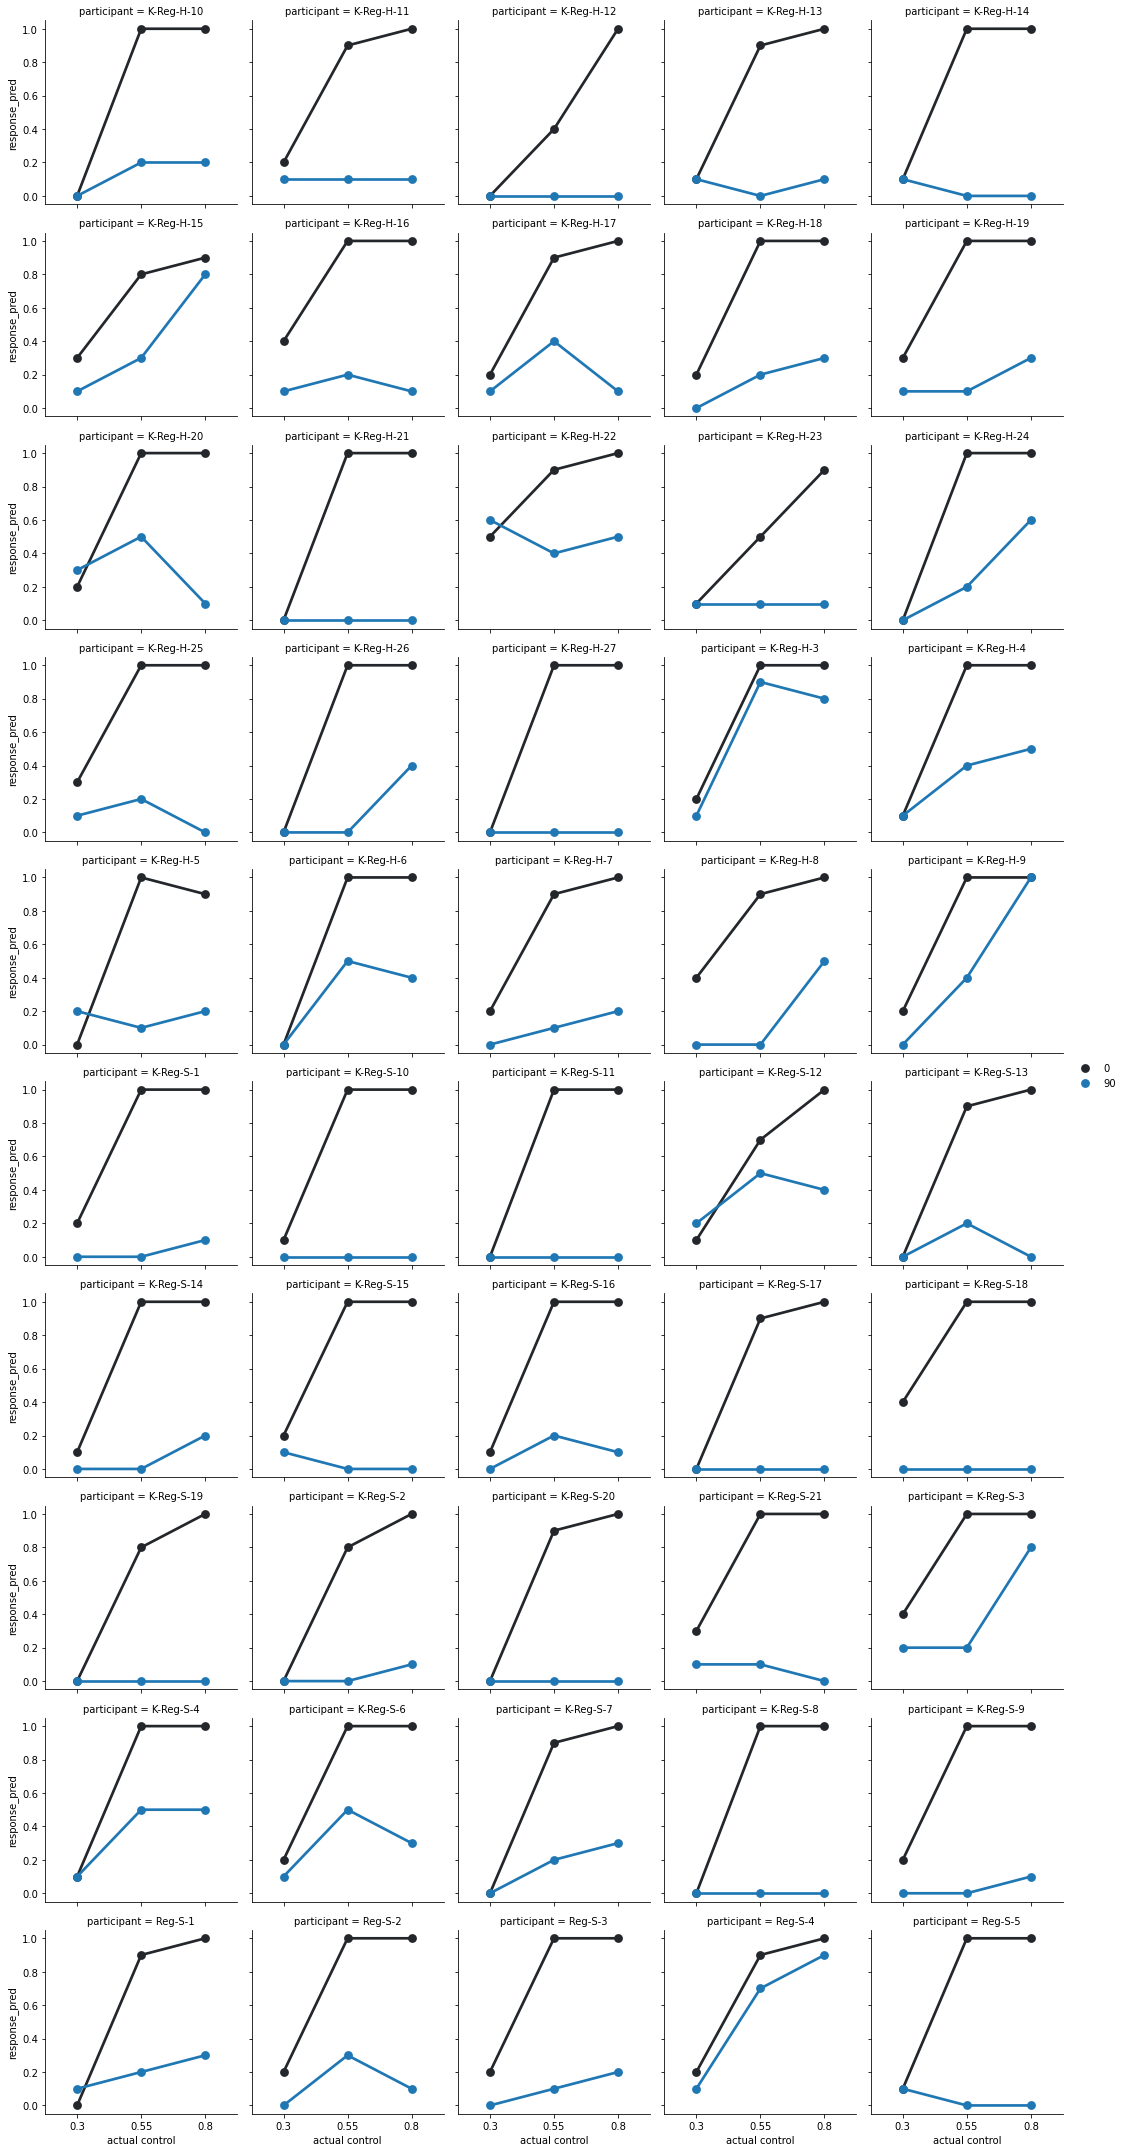

<Figure size 432x288 with 0 Axes>

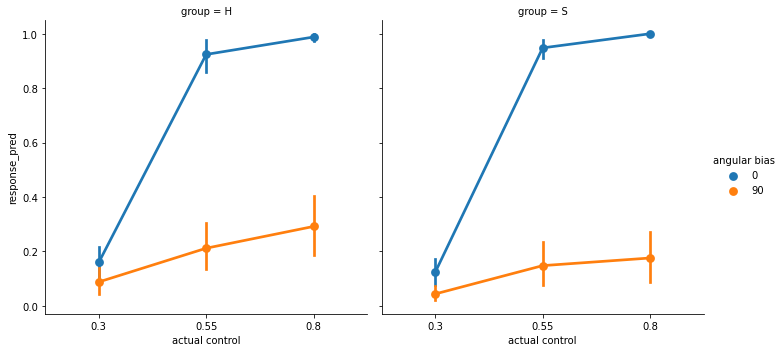

In [9]:
df_ = df.copy()
df_ = df_[['participant', 'actual control', 'angular bias', 'response_pred', 'group']]
df_ = df_.groupby(['participant', 'actual control', 'angular bias', 'group']).mean()
df_ = df_.reset_index()

grid = sns.FacetGrid(col='participant', col_wrap=5, data=df_)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='response_pred', 
                   hue='angular bias')
grid.add_legend()


plt.figure()
sns.catplot(x='actual control', y='response_pred', hue='angular bias', data=df_, col='group', kind='point')


,participant,group,b0,b1,b2
0,K-Reg-H-10,H,1.976842,-3.230715,-0.339573
1,K-Reg-H-11,H,2.412316,-3.034829,-0.309967
2,K-Reg-H-12,H,0.982205,-3.189150,-0.627470
3,K-Reg-H-13,H,1.267001,-3.030674,-0.374198
4,K-Reg-H-14,H,2.434450,-3.543134,-0.406435


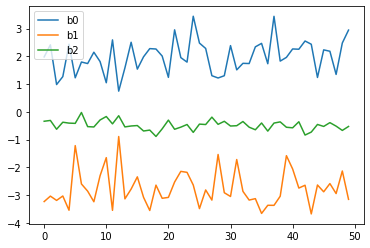

In [81]:
df_ = df[['participant', 'group', 'b0', 'b1', 'b2', 'mu']].groupby(['participant', 'group']).mean()
df_ = df_.reset_index()
df_.plot()
df_.head()

## Correlation with reaching noise-free performance

Basically nothing happens

In [82]:
df_ctrl = [utils.LoadData.behaviorData(subj, utils.ExpInfo.taskName[2]) for subj in subjs]
df_ctrl = pd.concat(df_ctrl, axis=0)
df_ctrl = df_ctrl.query('`actual control`==1')[['participant', 'group', 'number of reaching']]
df_ctrl = df_ctrl.groupby(['participant', 'group']).mean().reset_index()
df_m = df_.merge(df_ctrl, on=['participant', 'group'])
df_m['mu'] = -(df_m['b0'] / df_m['b1'])
df_m.head()

,participant,group,b0,b1,b2,number of reaching,mu
0,K-Reg-H-10,H,1.976842,-3.230715,-0.339573,8.85,0.611890
1,K-Reg-H-11,H,2.412316,-3.034829,-0.309967,9.15,0.794877
2,K-Reg-H-12,H,0.982205,-3.189150,-0.627470,8.85,0.307983
3,K-Reg-H-13,H,1.267001,-3.030674,-0.374198,7.30,0.418059
4,K-Reg-H-14,H,2.434450,-3.543134,-0.406435,9.40,0.687089


In [84]:
print(df_m.corr())

# compute stats 
import pingouin as pg
print(pg.corr(df_m['b0'], df_m['b1'], method='pearson'))
print(pg.corr(df_m['b0'], df_m['b2'], method='pearson'))


                          b0        b1        b2  number of reaching        mu
b0                  1.000000 -0.403094 -0.415777           -0.038583  0.609361
b1                 -0.403094  1.000000  0.194204            0.002169  0.462330
b2                 -0.415777  0.194204  1.000000           -0.142038 -0.280947
number of reaching -0.038583  0.002169 -0.142038            1.000000 -0.049374
mu                  0.609361  0.462330 -0.280947           -0.049374  1.000000
          n         r           CI95%     p-val    BF10     power
pearson  50 -0.403094  [-0.61, -0.14]  0.003702  10.562  0.840186
          n         r           CI95%     p-val    BF10     power
pearson  50 -0.415777  [-0.62, -0.16]  0.002674  14.086  0.864458


<AxesSubplot:xlabel='b0', ylabel='b1'>

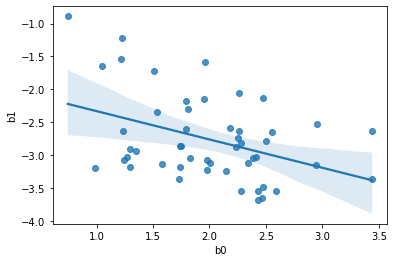

In [85]:
sns.regplot(x='b0', y='b1', data=df_m)

<AxesSubplot:xlabel='b0', ylabel='b1'>

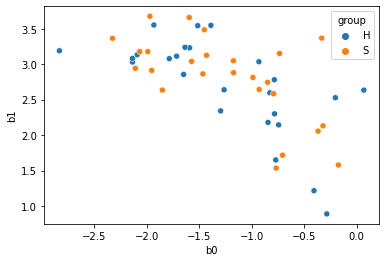

In [69]:
sns.scatterplot(x='b0', y='b1', data=df_m, hue='group')

<AxesSubplot:xlabel='participant', ylabel='mu'>

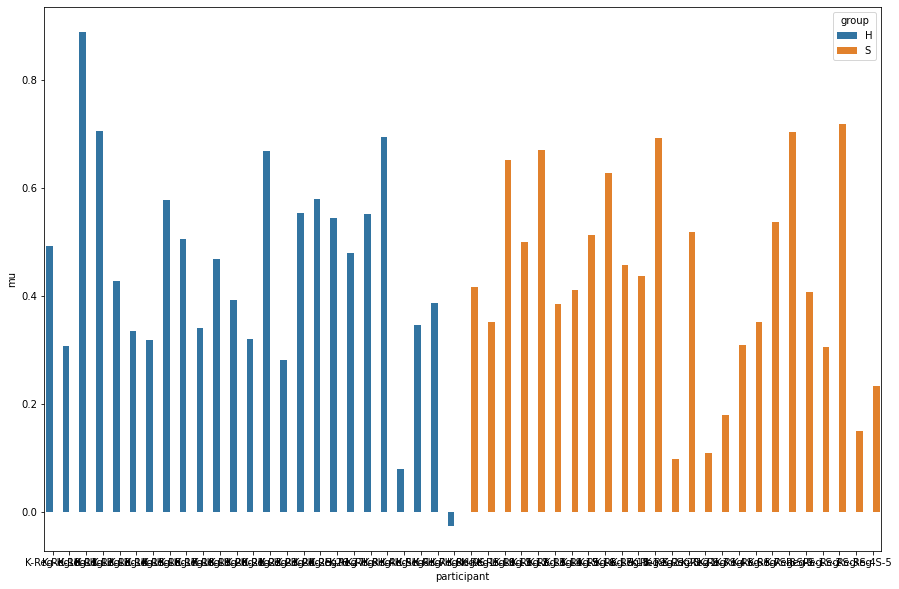

In [76]:
# set figure size
plt.figure(figsize=(15, 10))
sns.barplot(x='participant', y='mu', data=df_m, hue='group')

In [78]:
df_m.corr()

,b0,b1,b2,number of reaching,mu
b0,1.000000,-0.646436,-0.069482,-0.068941,-0.931191
b1,-0.646436,1.000000,0.194204,-0.002172,0.349850
b2,-0.069482,0.194204,1.000000,0.142009,-0.039695
number of reaching,-0.068941,-0.002172,0.142009,1.000000,0.086525
mu,-0.931191,0.349850,-0.039695,0.086525,1.000000


# individual

[[ 1.88197113 -0.19730399]] [0.28970754]


<AxesSubplot:xlabel='actual control', ylabel='response_pred'>

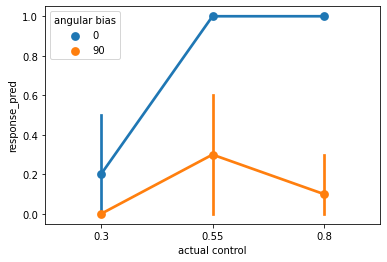

In [7]:
subj = subjs[46]
df_beh = utils.LoadData.behaviorData(subj, task)

df_ = pd.concat([df_beh, pd.DataFrame(d)], axis=1)
X = df_[['dist_mean']]
X = df_[['v_mean']]
X = df_[['dist_mean', 'v_mean']]
# X = df_[['dist_mean', 'v_mean', 'dist_sd', 'v_sd']]
# X = df_[['dist_mean']]
X = StandardScaler().fit_transform(X)

y = df_['response']
# class_weightdict = {0: 1, 1: 1}
LR = LogisticRegression(fit_intercept=True, class_weight='balanced').fit(X, y)
df_['response_pred'] = LR.predict(X)
print(LR.coef_, LR.intercept_)

plt.figure()
sns.pointplot(x='actual control', y='response_pred', hue='angular bias', data=df_)

<AxesSubplot:xlabel='actual control', ylabel='v_sd'>

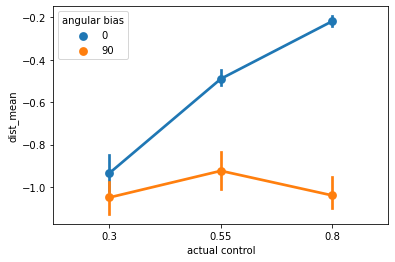

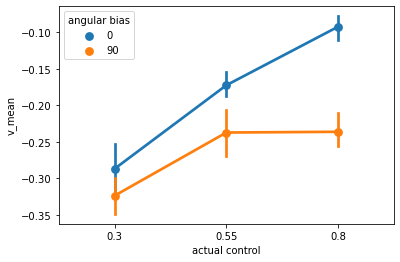

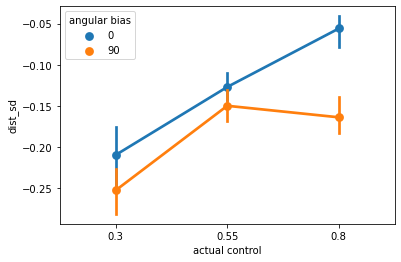

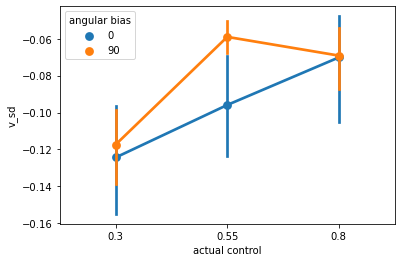

In [89]:
d_ = pd.DataFrame(d)
df_ = pd.concat([df_beh, d_], axis=1)   
# df_['dist_mean']=1-df_['dist_mean']
plt.figure()
sns.pointplot(x='actual control', y='dist_mean', hue='angular bias', data=df_)
plt.figure()
sns.pointplot(x='actual control', y='v_mean', hue='angular bias', data=df_)
plt.figure()
sns.pointplot(x='actual control', y='dist_sd', hue='angular bias', data=df_)
plt.figure()
sns.pointplot(x='actual control', y='v_sd', hue='angular bias', data=df_)

In [90]:
# n = 2
# mean = np.zeros(n)
# cov = np.eye(n)
# rv = multivariate_normal(mean=mean, cov=cov)
# samples = rv.rvs(10000)

# dist_sample = distance.cdist(np.expand_dims(mean, 0), samples, 'euclidean').flatten()
# sns.distplot(dist_sample)
# # plt.plot(samples[:, 0], samples[:, 1], 'o')

In [91]:
def binary_separability_all(h_trial, h_disp_trial):
    """
    Compute the binary separability of the given dataset.
    """

    from sklearn.cluster import KMeans
    from sklearn.mixture import GaussianMixture
    # hidden action plan velocity
    vh = np.diff(h_trial, axis=0)
    vh_disp = np.diff(h_disp_trial, axis=0)

    Xs = {}

    X = np.vstack([h_trial, h_disp_trial])
    Xs['p'] = X
    X = np.vstack([vh, vh_disp])
    Xs['v'] = X


    hvh = np.hstack([h_trial[:-1], vh])
    hvh_disp = np.hstack([h_disp_trial[:-1], vh_disp])
    X = np.vstack([hvh, hvh_disp])
    Xs['p+v'] = X


    diff = h_disp_trial - h_trial
    diff_zero = np.zeros_like(diff)
    X = np.vstack([diff, diff_zero])
    Xs['p_diff'] = X


    diff = vh_disp - vh
    diff_zero = np.zeros_like(diff)
    X = np.vstack([diff, diff_zero])
    Xs['v_diff'] = X

    diff1 = h_disp_trial - h_trial
    diff2 = vh_disp - vh
    diff = np.hstack([diff1[:-1, :], diff2])
    diff_zero = np.zeros_like(diff)
    X = np.vstack([diff, diff_zero])
    Xs['p_diff+v_diff'] = X

    def binary_separability(X, nRun=10):
        labels = np.tile(np.array([0, 1]), [int(X.shape[0]/2), 1]).flatten(order='F')
        
        acc_run = []
        for iRun in range(nRun):
            # labels_ = KMeans(n_clusters=2, random_state=4).fit_predict(X)
            labels_ = GaussianMixture(n_components=2, random_state=iRun).fit_predict(X)
            
            acc = np.mean(labels_ == labels)
            if acc < 0.5:
                acc = 1-acc
            acc_run.append(acc)
        acc_run = np.array(acc_run).mean()
        return -acc

    for name, X in Xs.items():
        # print(name, binary_separability(X))
        Xs[name] = binary_separability(X)
    return Xs

# binary_separability_all(h_trial, h_disp_trial)

In [92]:
# subj = subjs[5]
# iTrial = 0
wSize = 60


df_beh = utils.LoadData.behaviorData(subj, task)
_, h, _ = utils.LoadData.xhy(subj, task, wSize=wSize)
_, h_disp, _ = utils.LoadData.xhy_disp(subj, task, wSize=wSize)
dist_measure = 'euclidean'

# dist_timeSeries = []
# v_timeSeries = []
d = []
bs = []
for iTrial in range(len(h)):
    h_trial = h[iTrial][:-1, :]
    h_disp_trial = h_disp[iTrial]

    # hidden action plan velocity
    vh = np.diff(h_trial, axis=0)
    vh_disp_dot = np.diff(h_disp_trial, axis=0)

    dist_timeSeries_ = paired_distances(h_trial, h_disp_trial, metric=dist_measure)
    v_timeSeries_ = paired_distances(vh, vh_disp_dot, metric=dist_measure)
    
    d.append({'dist_mean': 1-dist_timeSeries_.mean(), 
              'dist_sd': -dist_timeSeries_.std(),
              'v_mean': 1-v_timeSeries_.mean(),
              'v_sd': -v_timeSeries_.std()})
    
    
    
    bs.append(binary_separability_all(h_trial, h_disp_trial))


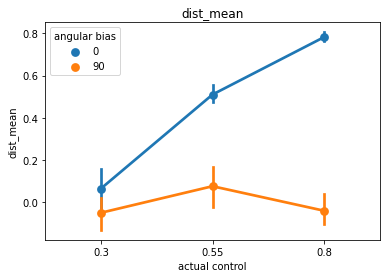

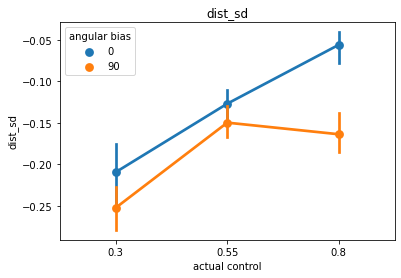

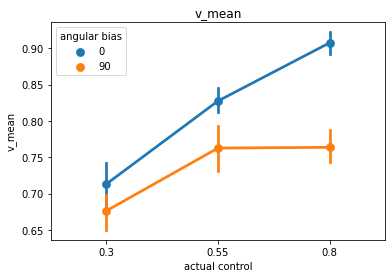

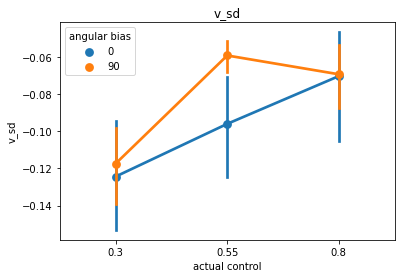

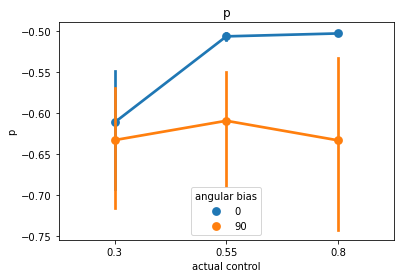

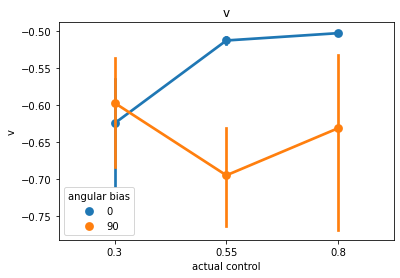

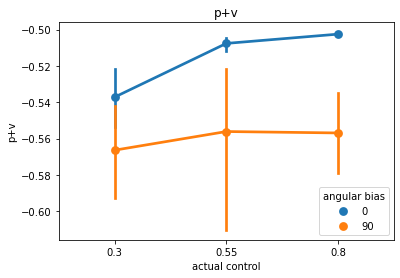

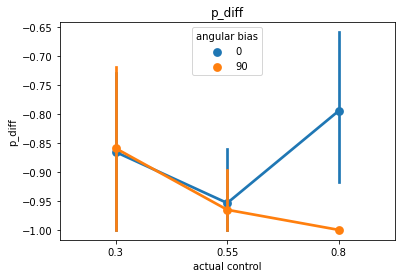

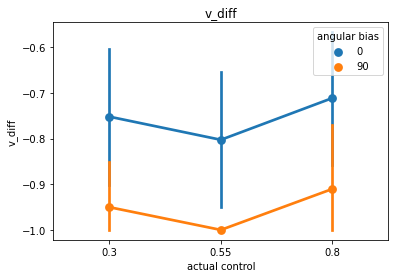

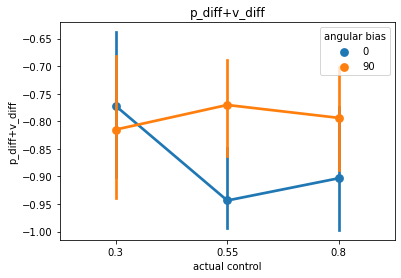

In [93]:
df_ = pd.concat([df_beh, pd.DataFrame(d), pd.DataFrame(bs)], axis=1)
columns = df_.loc[:, 'dist_mean':].columns.values
for column in columns:
    plt.figure()
    sns.pointplot(x='actual control', y=column, hue='angular bias', data=df_)
    plt.title(column)


[[0.31458075 0.96385792 0.22068696]] [-0.09569334]


<AxesSubplot:xlabel='actual control', ylabel='response_pred'>

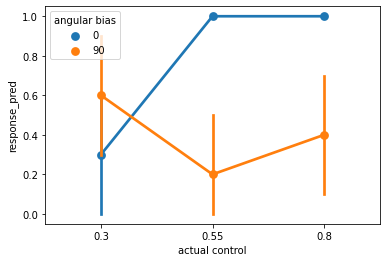

In [111]:
# df_ = pd.concat([df_beh, pd.DataFrame(d)], axis=1)
# X = df_[['p']]
# X = df_[['v']]
# X = df_[['p', 'v']]
X = df_[['p+v']]
X = df_[['p', 'v', 'p+v']]
# X = df_[['p_diff', 'v_diff']]
X = StandardScaler().fit_transform(X)

y = df_['response']
LR = LogisticRegression(fit_intercept=True, class_weight='balanced').fit(X, y)
df_['response_pred'] = LR.predict(X)
print(LR.coef_, LR.intercept_)

plt.figure()
sns.pointplot(x='actual control', y='response_pred', hue='angular bias', data=df_)

# By trial

In [95]:
# subj = subjs[10]
# # iTrial = 0
# wSize = 60


# df_beh = utils.LoadData.behaviorData(subj, task)
# _, h, _ = utils.LoadData.xhy(subj, task, wSize=wSize)
# _, h_disp, _ = utils.LoadData.xhy_disp(subj, task, wSize=wSize)
# dist_measure = 'euclidean'


In [96]:
# iTrial = 5
# h_trial = h[iTrial][:-1, :]
# h_disp_trial = h_disp[iTrial]

# # hidden action plan velocity
# vh = np.diff(h_trial, axis=0)
# vh_disp = np.diff(h_disp_trial, axis=0)

# dist_timeSeries_ = paired_distances(h_trial, h_disp_trial, metric=dist_measure)
# v_timeSeries_ = paired_distances(vh, vh_disp, metric=dist_measure)

# # d.append({'dist_mean': 1-dist_timeSeries_.mean(), 
# #             'dist_sd': -dist_timeSeries_.std(),
# #             'v_mean': 1-v_timeSeries_.mean(),
# #             'v_sd': -v_timeSeries_.std()})


    

In [97]:
# print(df_beh.iloc[iTrial])


In [98]:
# from sklearn.cluster import KMeans
# from sklearn.mixture import GaussianMixture
# Xs = {}

# X = np.vstack([h_trial, h_disp_trial])
# Xs['position'] = X
# X = np.vstack([vh, vh_disp])
# Xs['velocity'] = X


# hvh = np.hstack([h_trial[:-1], vh])
# hvh_disp = np.hstack([h_disp_trial[:-1], vh_disp])
# X = np.vstack([hvh, hvh_disp])
# Xs['p+v'] = X


# diff = h_disp_trial - h_trial
# diff_zero = np.zeros_like(diff)
# X = np.vstack([diff, diff_zero])
# Xs['p_diff'] = X


# diff = vh_disp - vh
# diff_zero = np.zeros_like(diff)
# X = np.vstack([diff, diff_zero])
# Xs['v_diff'] = X

# diff1 = h_disp_trial - h_trial
# diff2 = vh_disp - vh
# diff = np.hstack([diff1[:-1, :], diff2])
# diff_zero = np.zeros_like(diff)
# X = np.vstack([diff, diff_zero])
# Xs['p_diff+v_diff'] = X

# def binary_separability(X, nRun=10):
#     labels = np.tile(np.array([0, 1]), [int(X.shape[0]/2), 1]).flatten(order='F')
    
#     acc_run = []
#     for iRun in range(nRun):
#         # labels_ = KMeans(n_clusters=2, random_state=4).fit_predict(X)
#         labels_ = GaussianMixture(n_components=2, random_state=0).fit_predict(X)
        
#         acc = np.mean(labels_ == labels)
#         if acc < 0.5:
#             acc = 1-acc
#         acc_run.append(acc)
#     acc_run = np.array(acc_run).mean()
#     return acc

# for name, X in Xs.items():
#     print(name, binary_separability(X))


In [99]:


# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(dist_timeSeries_)
# ax.set_ylim([0, 2])
# plt.title('position dist')



# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(v_timeSeries_)
# ax.set_ylim([0, 2])
# plt.title('v dist')


# # intention traj diff

# dd = utils.DataProcessing.diff(h_trial)
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(dd)
# ax.set_ylim([0, 2])
# plt.title('intention t t+1')

# dd = utils.DataProcessing.diff(h_disp_trial)
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(dd)
# ax.set_ylim([0, 2])
# plt.title('disp t t+1')

In [100]:
# diff = h_disp_trial - h_trial
# mean = np.mean(diff, axis=0)
# cov = np.cov(diff, rowvar=0)

# from scipy.stats import multivariate_normal
# rv = multivariate_normal(mean=mean, cov=cov)
# nSample = 10000
# samples = rv.rvs(nSample)

In [101]:
# from scipy.spatial import distance
# dist_sample = distance.cdist(np.expand_dims(mean, 0), samples, 'euclidean').flatten()
# # dist_sample = paired_distances(np.tile(mean, (nSample, 1)), samples, metric='euclidean')
# dist_target = distance.cdist(np.expand_dims(mean, 0), np.zeros((1, diff.shape[1])), 'euclidean')

In [102]:
# plt.plot(dist_sample)
# plt.plot(dist_target, 'or')

In [103]:
# n = 2
# mean = np.zeros(n)
# cov = np.eye(n)
# rv = multivariate_normal(mean=mean, cov=cov)
# samples = rv.rvs(10000)

# dist_sample = distance.cdist(np.expand_dims(mean, 0), samples, 'euclidean').flatten()
# sns.distplot(dist_sample)
# # plt.plot(samples[:, 0], samples[:, 1], 'o')